In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def single_category_regressor(features, context, unitsNumber = 64):
    features = concatenate([features, context])
    
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    dense_2 = Dense(unitsNumber, activation = 'elu')(dense_1_dropout)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return Dense(1, activation='sigmoid')(dense_2_dropout)

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)


dense_1 = Dense(512, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(512, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

single_category_layer = concatenate([
    single_category_regressor(features, dense_2_dropout, 128),
    single_category_regressor(features, dense_2_dropout, 128),
    single_category_regressor(features, dense_2_dropout, 128),
    single_category_regressor(features, dense_2_dropout, 128),
    single_category_regressor(features, dense_2_dropout, 128),
    single_category_regressor(features, dense_2_dropout, 128),
])

output_layer = average([output_layer, single_category_layer])

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21376/102124 [=====>........................] - ETA: 8:24 - loss: 0.1820 - acc: 0.9027

 59904/102124 [================>.............] - ETA: 4:14 - loss: 0.1179 - acc: 0.9461

 95552/102124 [===========================>..] - ETA: 39s - loss: 0.1017 - acc: 0.9558

102124/102124 [==============================] - 661s 6ms/step - loss: 0.0999 - acc: 0.9568 - val_loss: 0.0681 - val_acc: 0.9704
Epoch 2/32
 11200/102124 [==>...........................] - ETA: 9:20 - loss: 0.0720 - acc: 0.9720

 63776/102124 [=================>............] - ETA: 3:51 - loss: 0.0663 - acc: 0.9753

102112/102124 [============================>.] - ETA: 0s - loss: 0.0642 - acc: 0.9764

102124/102124 [==============================] - 652s 6ms/step - loss: 0.0642 - acc: 0.9764 - val_loss: 0.0735 - val_acc: 0.9779
roc-auc: 0.9643 - roc-auc_val: 0.9627                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 9:10 - loss: 0.0584 - acc: 0.9785

 71520/102124 [====================>.........] - ETA: 3:00 - loss: 0.0573 - acc: 0.9791

102124/102124 [==============================] - 643s 6ms/step - loss: 0.0565 - acc: 0.9794 - val_loss: 0.0506 - val_acc: 0.9812
Epoch 4/32
  2176/102124 [..............................] - ETA: 10:24 - loss: 0.0486 - acc: 0.9814

 43904/102124 [===========>..................] - ETA: 5:59 - loss: 0.0528 - acc: 0.9804

102112/102124 [============================>.] - ETA: 0s - loss: 0.0521 - acc: 0.9807

102124/102124 [==============================] - 660s 6ms/step - loss: 0.0521 - acc: 0.9807 - val_loss: 0.0472 - val_acc: 0.9818
roc-auc: 0.9814 - roc-auc_val: 0.9784                                                                                                    
Epoch 5/32
  8736/102124 [=>............................] - ETA: 9:09 - loss: 0.0474 - acc: 0.9821

 93024/102124 [==========================>...] - ETA: 53s - loss: 0.0497 - acc: 0.9813

102124/102124 [==============================] - 644s 6ms/step - loss: 0.0495 - acc: 0.9813 - val_loss: 0.0477 - val_acc: 0.9824
Epoch 6/32
  9952/102124 [=>............................] - ETA: 9:31 - loss: 0.0487 - acc: 0.9814

 48224/102124 [=============>................] - ETA: 5:28 - loss: 0.0497 - acc: 0.9812

 93792/102124 [==========================>...] - ETA: 50s - loss: 0.0483 - acc: 0.9816

102124/102124 [==============================] - 656s 6ms/step - loss: 0.0484 - acc: 0.9816 - val_loss: 0.0467 - val_acc: 0.9824
roc-auc: 0.9838 - roc-auc_val: 0.9804                                                                                                    
Epoch 7/32
  6752/102124 [>.............................] - ETA: 9:21 - loss: 0.0493 - acc: 0.9806

 58688/102124 [================>.............] - ETA: 4:15 - loss: 0.0467 - acc: 0.9822

 94016/102124 [==========================>...] - ETA: 48s - loss: 0.0468 - acc: 0.9822

102124/102124 [==============================] - 651s 6ms/step - loss: 0.0469 - acc: 0.9822 - val_loss: 0.0484 - val_acc: 0.9824
Epoch 8/32
 10400/102124 [==>...........................] - ETA: 9:14 - loss: 0.0446 - acc: 0.9827

 49504/102124 [=============>................] - ETA: 5:20 - loss: 0.0453 - acc: 0.9824

 93664/102124 [==========================>...] - ETA: 50s - loss: 0.0453 - acc: 0.9824

102124/102124 [==============================] - 652s 6ms/step - loss: 0.0457 - acc: 0.9822 - val_loss: 0.0427 - val_acc: 0.9829
roc-auc: 0.9894 - roc-auc_val: 0.9856                                                                                                    
Epoch 9/32
  6752/102124 [>.............................] - ETA: 9:21 - loss: 0.0463 - acc: 0.9819

 41728/102124 [===========>..................] - ETA: 6:04 - loss: 0.0443 - acc: 0.9829

 80064/102124 [======================>.......] - ETA: 2:14 - loss: 0.0445 - acc: 0.9826

102124/102124 [==============================] - 657s 6ms/step - loss: 0.0447 - acc: 0.9826 - val_loss: 0.0436 - val_acc: 0.9831
Epoch 10/32
  5376/102124 [>.............................] - ETA: 9:32 - loss: 0.0414 - acc: 0.9841

 43840/102124 [===========>..................] - ETA: 5:44 - loss: 0.0432 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9828

102124/102124 [==============================] - 642s 6ms/step - loss: 0.0438 - acc: 0.9828 - val_loss: 0.0447 - val_acc: 0.9833

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00019614602206274867.
roc-auc: 0.9894 - roc-auc_val: 0.9848                                                                                                    
Epoch 11/32
  5696/102124 [>.............................] - ETA: 10:05 - loss: 0.0401 - acc: 0.9838

 41536/102124 [===========>..................] - ETA: 6:13 - loss: 0.0440 - acc: 0.9828

 94560/102124 [==========================>...] - ETA: 46s - loss: 0.0433 - acc: 0.9831

102124/102124 [==============================] - 660s 6ms/step - loss: 0.0435 - acc: 0.9830 - val_loss: 0.0418 - val_acc: 0.9839
Epoch 12/32
 11040/102124 [==>...........................] - ETA: 9:00 - loss: 0.0414 - acc: 0.9832

 74336/102124 [====================>.........] - ETA: 2:43 - loss: 0.0425 - acc: 0.9830

102124/102124 [==============================] - 643s 6ms/step - loss: 0.0428 - acc: 0.9830 - val_loss: 0.0424 - val_acc: 0.9840
roc-auc: 0.9911 - roc-auc_val: 0.9865                                                                                                    
Epoch 13/32
  1952/102124 [..............................] - ETA: 10:06 - loss: 0.0421 - acc: 0.9837

 91744/102124 [=========================>....] - ETA: 1:02 - loss: 0.0424 - acc: 0.9831

102124/102124 [==============================] - 651s 6ms/step - loss: 0.0424 - acc: 0.9831 - val_loss: 0.0430 - val_acc: 0.9834
Epoch 14/32
 10048/102124 [=>............................] - ETA: 9:02 - loss: 0.0415 - acc: 0.9836

 49184/102124 [=============>................] - ETA: 5:13 - loss: 0.0417 - acc: 0.9833

 83424/102124 [=======================>......] - ETA: 1:52 - loss: 0.0421 - acc: 0.9833

102124/102124 [==============================] - 660s 6ms/step - loss: 0.0419 - acc: 0.9835 - val_loss: 0.0414 - val_acc: 0.9841
roc-auc: 0.9918 - roc-auc_val: 0.9867                                                                                                    
Epoch 15/32
  4032/102124 [>.............................] - ETA: 9:40 - loss: 0.0421 - acc: 0.9839

 41888/102124 [===========>..................] - ETA: 5:57 - loss: 0.0423 - acc: 0.9832

 97216/102124 [===========================>..] - ETA: 29s - loss: 0.0414 - acc: 0.9837

102124/102124 [==============================] - 646s 6ms/step - loss: 0.0413 - acc: 0.9837 - val_loss: 0.0415 - val_acc: 0.9838
Epoch 16/32
 12032/102124 [==>...........................] - ETA: 8:57 - loss: 0.0410 - acc: 0.9837

 52640/102124 [==============>...............] - ETA: 5:02 - loss: 0.0410 - acc: 0.9837

 94336/102124 [==========================>...] - ETA: 47s - loss: 0.0413 - acc: 0.9836

102124/102124 [==============================] - 660s 6ms/step - loss: 0.0409 - acc: 0.9838 - val_loss: 0.0409 - val_acc: 0.9842
roc-auc: 0.993 - roc-auc_val: 0.9873                                                                                                    
Epoch 17/32
  6880/102124 [=>............................] - ETA: 9:19 - loss: 0.0392 - acc: 0.9843

 52256/102124 [==============>...............] - ETA: 4:55 - loss: 0.0406 - acc: 0.9840

 88000/102124 [========================>.....] - ETA: 1:24 - loss: 0.0406 - acc: 0.9839

102124/102124 [==============================] - 657s 6ms/step - loss: 0.0405 - acc: 0.9840 - val_loss: 0.0409 - val_acc: 0.9840
Epoch 18/32
  8064/102124 [=>............................] - ETA: 9:41 - loss: 0.0361 - acc: 0.9856

 54432/102124 [==============>...............] - ETA: 4:45 - loss: 0.0388 - acc: 0.9845

100608/102124 [============================>.] - ETA: 9s - loss: 0.0398 - acc: 0.9841

102124/102124 [==============================] - 648s 6ms/step - loss: 0.0398 - acc: 0.9842 - val_loss: 0.0406 - val_acc: 0.9840
roc-auc: 0.9934 - roc-auc_val: 0.9873                                                                                                    
Epoch 19/32
  8320/102124 [=>............................] - ETA: 9:12 - loss: 0.0392 - acc: 0.9839

 66688/102124 [==================>...........] - ETA: 3:29 - loss: 0.0398 - acc: 0.9841

101632/102124 [============================>.] - ETA: 2s - loss: 0.0397 - acc: 0.9842

102124/102124 [==============================] - 655s 6ms/step - loss: 0.0397 - acc: 0.9842 - val_loss: 0.0409 - val_acc: 0.9842
Epoch 20/32
 13152/102124 [==>...........................] - ETA: 9:08 - loss: 0.0395 - acc: 0.9840

 77824/102124 [=====================>........] - ETA: 2:26 - loss: 0.0396 - acc: 0.9842

102124/102124 [==============================] - 651s 6ms/step - loss: 0.0395 - acc: 0.9843 - val_loss: 0.0409 - val_acc: 0.9839
roc-auc: 0.9935 - roc-auc_val: 0.987                                                                                                    
Epoch 21/32
  2912/102124 [..............................] - ETA: 9:50 - loss: 0.0388 - acc: 0.9853

 43776/102124 [===========>..................] - ETA: 5:45 - loss: 0.0398 - acc: 0.9840

 80640/102124 [======================>.......] - ETA: 2:07 - loss: 0.0390 - acc: 0.9844

102124/102124 [==============================] - 653s 6ms/step - loss: 0.0391 - acc: 0.9844 - val_loss: 0.0405 - val_acc: 0.9840
Epoch 22/32
  5120/102124 [>.............................] - ETA: 9:56 - loss: 0.0410 - acc: 0.9831

 46016/102124 [============>.................] - ETA: 5:40 - loss: 0.0386 - acc: 0.9846

 87296/102124 [========================>.....] - ETA: 1:28 - loss: 0.0388 - acc: 0.9844

102124/102124 [==============================] - 655s 6ms/step - loss: 0.0388 - acc: 0.9844 - val_loss: 0.0405 - val_acc: 0.9842
roc-auc: 0.994 - roc-auc_val: 0.9874                                                                                                    
Epoch 23/32
  5088/102124 [>.............................] - ETA: 9:51 - loss: 0.0389 - acc: 0.9852

 40064/102124 [==========>...................] - ETA: 6:20 - loss: 0.0385 - acc: 0.9846

 80544/102124 [======================>.......] - ETA: 2:09 - loss: 0.0384 - acc: 0.9846

102124/102124 [==============================] - 653s 6ms/step - loss: 0.0383 - acc: 0.9847 - val_loss: 0.0407 - val_acc: 0.9840

Epoch 00023: ReduceLROnPlateau reducing learning rate to 5.076577508589253e-05.
Epoch 24/32
  4128/102124 [>.............................] - ETA: 9:36 - loss: 0.0364 - acc: 0.9861

 59808/102124 [================>.............] - ETA: 4:10 - loss: 0.0384 - acc: 0.9845

 96256/102124 [===========================>..] - ETA: 35s - loss: 0.0385 - acc: 0.9845

102124/102124 [==============================] - 653s 6ms/step - loss: 0.0385 - acc: 0.9846 - val_loss: 0.0407 - val_acc: 0.9842
roc-auc: 0.9943 - roc-auc_val: 0.9872                                                                                                    
Epoch 25/32
  7104/102124 [=>............................] - ETA: 9:46 - loss: 0.0382 - acc: 0.9851

 64320/102124 [=================>............] - ETA: 3:47 - loss: 0.0384 - acc: 0.9847

102112/102124 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9846

102124/102124 [==============================] - 652s 6ms/step - loss: 0.0383 - acc: 0.9846 - val_loss: 0.0407 - val_acc: 0.9842
Epoch 26/32
 13888/102124 [===>..........................] - ETA: 8:43 - loss: 0.0373 - acc: 0.9848

 61184/102124 [================>.............] - ETA: 4:02 - loss: 0.0381 - acc: 0.9845

101984/102124 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9845

102124/102124 [==============================] - 648s 6ms/step - loss: 0.0382 - acc: 0.9845 - val_loss: 0.0409 - val_acc: 0.9841
roc-auc: 0.9943 - roc-auc_val: 0.987                                                                                                    
Epoch 27/32
  8256/102124 [=>............................] - ETA: 9:39 - loss: 0.0377 - acc: 0.9846

 45312/102124 [============>.................] - ETA: 5:44 - loss: 0.0376 - acc: 0.9849

 85504/102124 [========================>.....] - ETA: 1:39 - loss: 0.0376 - acc: 0.9848

102124/102124 [==============================] - 652s 6ms/step - loss: 0.0378 - acc: 0.9848 - val_loss: 0.0409 - val_acc: 0.9842
Epoch 28/32
  7552/102124 [=>............................] - ETA: 9:20 - loss: 0.0390 - acc: 0.9837

 49664/102124 [=============>................] - ETA: 5:19 - loss: 0.0392 - acc: 0.9841

 85856/102124 [========================>.....] - ETA: 1:39 - loss: 0.0379 - acc: 0.9847

102124/102124 [==============================] - 663s 6ms/step - loss: 0.0379 - acc: 0.9847 - val_loss: 0.0406 - val_acc: 0.9843
roc-auc: 0.9947 - roc-auc_val: 0.987                                                                                                    
Epoch 29/32
  4768/102124 [>.............................] - ETA: 9:32 - loss: 0.0363 - acc: 0.9857

 60672/102124 [================>.............] - ETA: 4:04 - loss: 0.0371 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9849

102124/102124 [==============================] - 643s 6ms/step - loss: 0.0377 - acc: 0.9849 - val_loss: 0.0412 - val_acc: 0.9842
Epoch 30/32
 13952/102124 [===>..........................] - ETA: 8:39 - loss: 0.0369 - acc: 0.9848

 50048/102124 [=============>................] - ETA: 5:13 - loss: 0.0370 - acc: 0.9851

 89472/102124 [=========================>....] - ETA: 1:16 - loss: 0.0372 - acc: 0.9850

102124/102124 [==============================] - 658s 6ms/step - loss: 0.0374 - acc: 0.9849 - val_loss: 0.0409 - val_acc: 0.9843
roc-auc: 0.9946 - roc-auc_val: 0.987                                                                                                    
Epoch 31/32
  5600/102124 [>.............................] - ETA: 9:26 - loss: 0.0398 - acc: 0.9844

 48512/102124 [=============>................] - ETA: 5:16 - loss: 0.0380 - acc: 0.9846

 96704/102124 [===========================>..] - ETA: 31s - loss: 0.0374 - acc: 0.9849

102124/102124 [==============================] - 643s 6ms/step - loss: 0.0374 - acc: 0.9849 - val_loss: 0.0406 - val_acc: 0.9843
Epoch 32/32
 11776/102124 [==>...........................] - ETA: 8:53 - loss: 0.0362 - acc: 0.9852

 50304/102124 [=============>................] - ETA: 5:10 - loss: 0.0371 - acc: 0.9851

 87840/102124 [========================>.....] - ETA: 1:26 - loss: 0.0374 - acc: 0.9848

102124/102124 [==============================] - 661s 6ms/step - loss: 0.0374 - acc: 0.9848 - val_loss: 0.0408 - val_acc: 0.9842
roc-auc: 0.9947 - roc-auc_val: 0.987                                                                                                    


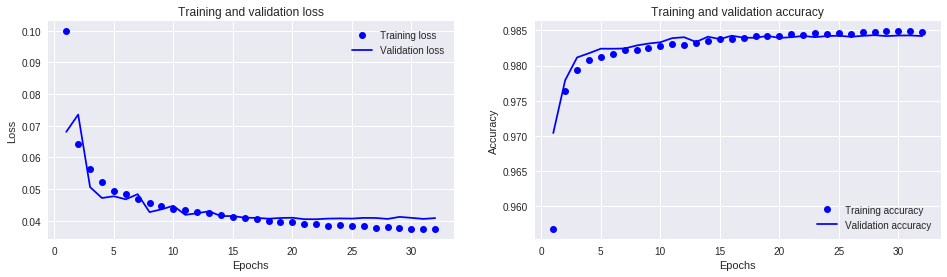

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 54s 2ms/step
([0.03902362880849846, 0.9847877044298984], 0.9890421752171417)


In [13]:
history = train_with_cv(model, batchSize=64, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42816/102124 [===========>..................] - ETA: 5:07 - loss: 0.1592 - acc: 0.9158

102124/102124 [==============================] - 559s 5ms/step - loss: 0.1100 - acc: 0.9496 - val_loss: 0.0636 - val_acc: 0.9773
Epoch 2/32
  5376/102124 [>.............................] - ETA: 8:07 - loss: 0.0700 - acc: 0.9760

102080/102124 [============================>.] - ETA: 0s - loss: 0.0648 - acc: 0.9771

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0648 - acc: 0.9771 - val_loss: 0.3012 - val_acc: 0.8366
roc-auc: 0.8922 - roc-auc_val: 0.8881                                                                                                    
Epoch 3/32
 17408/102124 [====>.........................] - ETA: 7:04 - loss: 0.0609 - acc: 0.9779

102080/102124 [============================>.] - ETA: 0s - loss: 0.0594 - acc: 0.9788

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0593 - acc: 0.9788 - val_loss: 0.0550 - val_acc: 0.9793
Epoch 4/32
 20352/102124 [====>.........................] - ETA: 6:51 - loss: 0.0570 - acc: 0.9792

102080/102124 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9804

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0538 - acc: 0.9804 - val_loss: 0.1081 - val_acc: 0.9715
roc-auc: 0.9799 - roc-auc_val: 0.9772                                                                                                    
Epoch 5/32
 17408/102124 [====>.........................] - ETA: 7:06 - loss: 0.0495 - acc: 0.9812

102080/102124 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9815

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0490 - acc: 0.9815 - val_loss: 0.0448 - val_acc: 0.9827
Epoch 6/32
 20352/102124 [====>.........................] - ETA: 6:50 - loss: 0.0472 - acc: 0.9820

102080/102124 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9819

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0472 - acc: 0.9819 - val_loss: 0.0434 - val_acc: 0.9829
roc-auc: 0.9895 - roc-auc_val: 0.9865                                                                                                    
Epoch 7/32
 17408/102124 [====>.........................] - ETA: 7:05 - loss: 0.0466 - acc: 0.9817

102080/102124 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9822

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0458 - acc: 0.9822 - val_loss: 0.0435 - val_acc: 0.9833
Epoch 8/32
 20352/102124 [====>.........................] - ETA: 6:52 - loss: 0.0436 - acc: 0.9829

102080/102124 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9827

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0448 - acc: 0.9827 - val_loss: 0.0426 - val_acc: 0.9837
roc-auc: 0.9905 - roc-auc_val: 0.9869                                                                                                    
Epoch 9/32
 17408/102124 [====>.........................] - ETA: 7:06 - loss: 0.0428 - acc: 0.9829

102080/102124 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9828

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0438 - acc: 0.9828 - val_loss: 0.0485 - val_acc: 0.9813
Epoch 10/32
 20288/102124 [====>.........................] - ETA: 6:50 - loss: 0.0430 - acc: 0.9832

102080/102124 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9830

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0431 - acc: 0.9830 - val_loss: 0.0437 - val_acc: 0.9834

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00019614602206274867.
roc-auc: 0.9895 - roc-auc_val: 0.9861                                                                                                    
Epoch 11/32
 11840/102124 [==>...........................] - ETA: 7:34 - loss: 0.0433 - acc: 0.9831

102080/102124 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9834

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0421 - acc: 0.9834 - val_loss: 0.0423 - val_acc: 0.9840
Epoch 12/32
 20288/102124 [====>.........................] - ETA: 6:52 - loss: 0.0400 - acc: 0.9836

102080/102124 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9835

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0415 - acc: 0.9835 - val_loss: 0.0471 - val_acc: 0.9825
roc-auc: 0.9913 - roc-auc_val: 0.9866                                                                                                    
Epoch 13/32
 17344/102124 [====>.........................] - ETA: 7:04 - loss: 0.0396 - acc: 0.9841

102080/102124 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9838

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0409 - acc: 0.9838 - val_loss: 0.0418 - val_acc: 0.9842
Epoch 14/32
 20288/102124 [====>.........................] - ETA: 6:51 - loss: 0.0410 - acc: 0.9837

102080/102124 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9838

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0403 - acc: 0.9838 - val_loss: 0.0442 - val_acc: 0.9835
roc-auc: 0.9913 - roc-auc_val: 0.9859                                                                                                    
Epoch 15/32
 17344/102124 [====>.........................] - ETA: 7:04 - loss: 0.0404 - acc: 0.9840

102080/102124 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9840

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0399 - acc: 0.9840 - val_loss: 0.0403 - val_acc: 0.9844
Epoch 16/32
 20288/102124 [====>.........................] - ETA: 6:51 - loss: 0.0375 - acc: 0.9848

102080/102124 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9842

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0394 - acc: 0.9842 - val_loss: 0.0405 - val_acc: 0.9841
roc-auc: 0.9939 - roc-auc_val: 0.9876                                                                                                    
Epoch 17/32
 17344/102124 [====>.........................] - ETA: 7:05 - loss: 0.0381 - acc: 0.9845

102080/102124 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9843

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0390 - acc: 0.9843 - val_loss: 0.0568 - val_acc: 0.9813
Epoch 18/32
 20288/102124 [====>.........................] - ETA: 6:51 - loss: 0.0374 - acc: 0.9846

102080/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9845

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0385 - acc: 0.9845 - val_loss: 0.0450 - val_acc: 0.9835
roc-auc: 0.9917 - roc-auc_val: 0.9841                                                                                                    
Epoch 19/32
 17344/102124 [====>.........................] - ETA: 7:06 - loss: 0.0374 - acc: 0.9849

102080/102124 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9846

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0379 - acc: 0.9846 - val_loss: 0.0437 - val_acc: 0.9839
Epoch 20/32
 20288/102124 [====>.........................] - ETA: 6:51 - loss: 0.0375 - acc: 0.9850

102080/102124 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9847

102124/102124 [==============================] - 551s 5ms/step - loss: 0.0379 - acc: 0.9847 - val_loss: 0.0410 - val_acc: 0.9843
roc-auc: 0.9949 - roc-auc_val: 0.9875                                                                                                    
Epoch 21/32
 17344/102124 [====>.........................] - ETA: 7:06 - loss: 0.0368 - acc: 0.9849

102080/102124 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9848

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0371 - acc: 0.9848 - val_loss: 0.0425 - val_acc: 0.9839

Epoch 00021: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
 16064/102124 [===>..........................] - ETA: 7:12 - loss: 0.0370 - acc: 0.9849

102080/102124 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9851

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0368 - acc: 0.9851 - val_loss: 0.0411 - val_acc: 0.9842
roc-auc: 0.995 - roc-auc_val: 0.9877                                                                                                    
Epoch 23/32
 17408/102124 [====>.........................] - ETA: 7:06 - loss: 0.0357 - acc: 0.9854

102080/102124 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9851

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0366 - acc: 0.9851 - val_loss: 0.0408 - val_acc: 0.9843
Epoch 24/32
 20288/102124 [====>.........................] - ETA: 6:51 - loss: 0.0369 - acc: 0.9849

102080/102124 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9851

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0363 - acc: 0.9851 - val_loss: 0.0408 - val_acc: 0.9845
roc-auc: 0.9955 - roc-auc_val: 0.9878                                                                                                    
Epoch 25/32
 17344/102124 [====>.........................] - ETA: 7:06 - loss: 0.0359 - acc: 0.9855

102080/102124 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9851

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0360 - acc: 0.9851 - val_loss: 0.0407 - val_acc: 0.9843


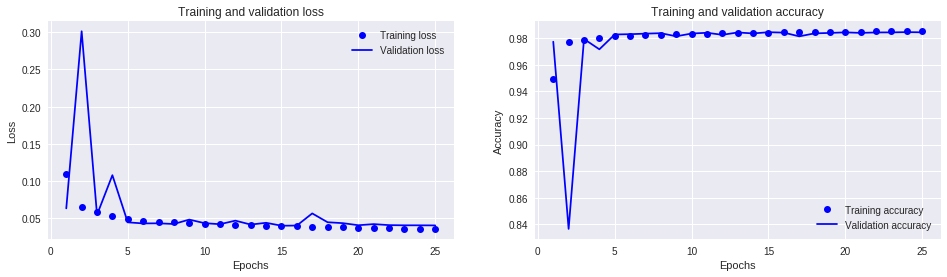

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 54s 2ms/step
([0.03872241154456076, 0.9848608151379376], 0.9899001188302372)
